# Data Acquisition

In [1]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

# librosa imports
import librosa
import librosa.display

# sklearn imports
# metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, f1_score, confusion_matrix, precision_recall_curve
#
from sklearn.model_selection import train_test_split
# ML Models
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# !sudo apt-get install p7zip-full

## Definition of Control Variables

In [2]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"

## Mount Google Drive

In [3]:
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')

Mounted at /content/drive


### Read Dataset and Get Frames

In [4]:
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]

In [5]:
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)
df_from_save.head(3)

,amp,amp_original,sf,sf_original,shape,shape_original,cough_start_end,label
key,,,,,,,,
a24e3cbe-eda1-40b9-8f9d-57c939ef3663,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...","[-6.8540386e-12, -6.674442e-12, 4.356682e-12, ...",16000,22050,[27840],[38367],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28b68991-11d8-48dd-b0ce-ab7bb44f0383,"[1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[157440],[216972],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0b2f75d7-f116-4f35-ae4c-f2018eab2794,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[155520],[214326],"[[1.651429, 1.891429], [2.022857, 2.331429], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
df_from_save.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, a24e3cbe-eda1-40b9-8f9d-57c939ef3663 to fd849b72-f4bf-4852-9bc2-fd9becc9571e
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   amp              300 non-null    object
 1   amp_original     300 non-null    object
 2   sf               300 non-null    int64 
 3   sf_original      300 non-null    int64 
 4   shape            300 non-null    object
 5   shape_original   300 non-null    object
 6   cough_start_end  150 non-null    object
 7   label            300 non-null    object
dtypes: int64(2), object(6)
memory usage: 21.1+ KB


### Get Frames
- Variable: all_frames_from_save

In [7]:
GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/utils/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)

from framing import Framing

['__init__.py', 'feature_extraction.py', 'framing.py', 'simple_ingestion.py', 'sono_cross_val.py', 'utils.py']


Frame size 1024, hop_length 512, count 82957
Frame size 2048, hop_length 1024, count 41222
Hop Length: 512


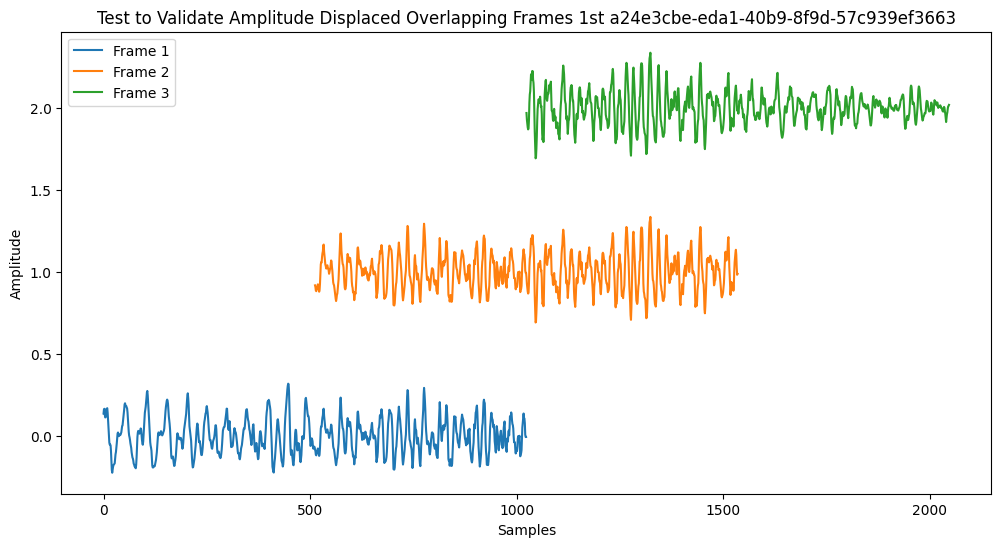

Hop Length: 512


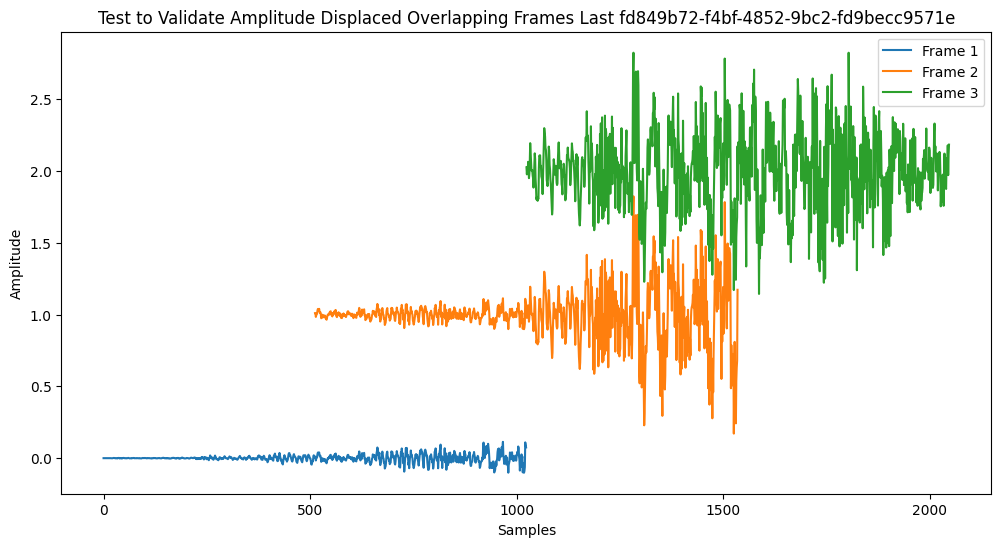

CPU times: user 6.46 s, sys: 294 ms, total: 6.75 s
Wall time: 9.08 s


In [9]:
%%time
frame = Framing()

all_frames_from_save = frame.apply_framing(audio_df=df_from_save, frame_sizes=[1024,2048])
df_frame_from_save = all_frames_from_save[1024]
df_frame_from_save.head(3)

visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
frame.visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

# Feature Extraction

## Spectogram
- Execution Time: Aproximately 2 minutes

In [10]:
from feature_extraction import Spectrogram
spectogram = Spectrogram()
#help(ffe)

starting: 1024
using n_fft:127, hop length:64, win_length:127


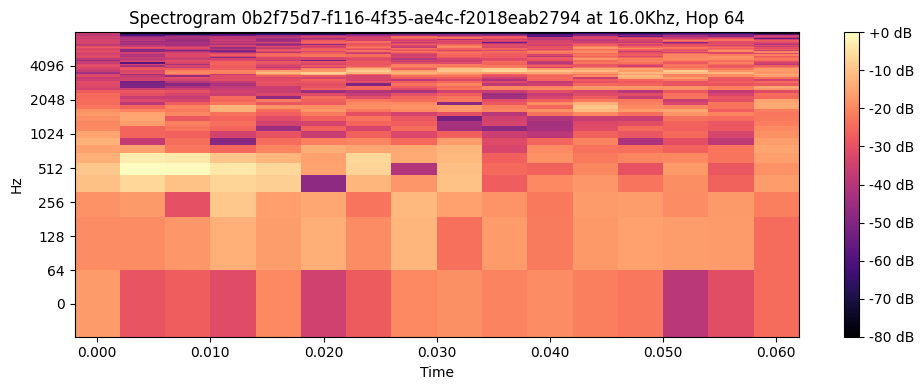

shape of stft (64, 16)
shape of the frame (1024,)
CPU times: user 1min 38s, sys: 3.57 s, total: 1min 42s
Wall time: 1min 48s


,key,sf,start,end,max_amp,frame_index,amp,label,stft
32377,9821da28-7655-4736-abf8-4c89582e407f,16000,0,1024,0.000260,0,"[2.4100282e-19, 4.552187e-20, -4.743169e-19, -...",0,"[[-51.059193, -51.059193, -51.059193, -51.0591..."
32378,9821da28-7655-4736-abf8-4c89582e407f,16000,512,1536,0.000527,1,"[-2.2809586e-13, 2.4235616e-13, -2.5261767e-13...",0,"[[-58.507927, -58.507927, -58.507927, -58.5079..."
32379,9821da28-7655-4736-abf8-4c89582e407f,16000,1024,2048,0.000737,2,"[5.5891054e-05, 0.00021803637, 0.00024021938, ...",0,"[[-18.885334, -32.74474, -24.695766, -35.10622..."
32380,9821da28-7655-4736-abf8-4c89582e407f,16000,1536,2560,0.000922,3,"[1.42881745e-05, -3.4426583e-05, 2.6231002e-05...",0,"[[-11.560276, -21.754932, -18.039566, -18.9115..."
32381,9821da28-7655-4736-abf8-4c89582e407f,16000,2048,3072,0.000922,4,"[0.0008490162, 0.0005570182, 0.00032274745, 0....",0,"[[-28.875217, -18.529537, -17.38078, -24.56908..."
...,...,...,...,...,...,...,...,...,...
32672,9821da28-7655-4736-abf8-4c89582e407f,16000,151040,152064,0.000035,295,"[-7.700891e-08, -1.1894869e-08, 8.98313e-08, -...",0,"[[-6.08123, -14.986046, -11.597763, -18.588615..."
32673,9821da28-7655-4736-abf8-4c89582e407f,16000,151552,152576,0.000057,296,"[2.8354348e-06, 2.6322938e-05, 2.7386598e-06, ...",0,"[[-19.990303, -18.756165, -19.800034, -8.37455..."
32674,9821da28-7655-4736-abf8-4c89582e407f,16000,152064,153088,0.000057,297,"[-1.4644161e-06, 2.2830393e-06, -5.1760608e-06...",0,"[[-4.9242554, -31.57219, -7.556259, -15.962433..."
32675,9821da28-7655-4736-abf8-4c89582e407f,16000,152576,153600,0.000062,298,"[-7.7346846e-07, 4.2284967e-09, 6.061488e-07, ...",0,"[[-27.41166, -6.1541214, -8.564682, -11.30648,..."


In [11]:
%%time
frame_size = 1024

obs = 64  #The number of frequency bins in the output (output bin size - obs)

n_fft = (obs * 2) - 1   #sub-frame size
win_length = n_fft  #apply windowing function to the entire length of the frame

hop_percent = 50
hop_length = (n_fft + 1) * hop_percent // 100

df_1024_spectogram = spectogram.get_spectogram_dataset(
    frame_size=frame_size,
    frames_dic=all_frames_from_save,
    limit=0,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    use_gpu=False
)

# save dataset in cache / temp storage, it helps to free up memory when fully implemented
spectogram.save_spectogram_data(df=df_1024_spectogram, file_name=frame_size, dir='', temporary=True)

#visualize only 1 spectogram for confirmation
key = 411
spectogram.plot_spectrogram( file_name=df_1024_spectogram['key'][key], S_DB=np.array(df_1024_spectogram['stft'][key]), sr=df_1024_spectogram['sf'][key], hop_length=64 )
print('shape of stft', df_1024_spectogram['stft'][key].shape )
print('shape of the frame', df_1024_spectogram['amp'][key].shape )

df_1024_spectogram[ df_1024_spectogram['key'] == '9821da28-7655-4736-abf8-4c89582e407f' ]

## Root Mean Square (RMS) Energy
- Execution Time: Aproximately <1 minute

In [12]:
# Two RMS functions
#   rms_from_amp(df)
#   rms_from_stft(df)

def rms_from_amp(df):
    """
    Compute root-mean-square (RMS) energy for each frame, from the 'amp' column in the DataFrame.

    Parameters:
        df (pd.DataFrame): Pandas DataFrame containing an 'amp' column.

    Returns:
        pd.DataFrame: Updated DataFrame 'df' with an additional 'rms_amp' column.

    """
    rms_values = []
    for index, row in df.iterrows():
        rms = librosa.feature.rms(y=row["amp"], frame_length=2048, hop_length=512)
        # rms = librosa.feature.rms(y=row["amp"])
        # y specifies from audio (amp) data
        rms_values.append(rms)

    df["rms_amp"] = rms_values

    return df

def rms_from_stft(df):
    """
    Compute root-mean-square (RMS) energy for each frame, from the 'stft' column (spectrogram) in the DataFrame.

    Parameters:
        df (pd.DataFrame): Pandas DataFrame containing an 'stft' column.

    Returns:
        pd.DataFrame: Updated DataFrame 'df' with an additional 'rms_stft' column.


    """
    rms_stft_values = []
    for index, row in df.iterrows():
        # rms_stft = librosa.feature.rms(S=row["stft"], frame_length=2048, hop_length=512)
        rms_stft = librosa.feature.rms(S=row["stft"])
        # S specifies from 'stft' data
        # No need to specify frame length and hop_length, infer from data
        rms_stft_values.append(rms_stft)

    df["rms_stft"] = rms_stft_values

    return df

In [13]:
# frame = Framing()

# all_frames_from_save = frame.apply_framing(audio_df=df_from_save, frame_sizes=[1024,2048])
# df_frame_from_save = all_frames_from_save[1024]
# df_frame_from_save.head(3)

In [14]:
df_frame_from_save.head(3)

,key,sf,start,end,max_amp,frame_index,amp,label
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,1024,0.000088,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,512,1536,0.000068,1,"[3.0801788e-05, 6.093162e-05, 3.560784e-05, -6...",0
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,2048,0.000066,2,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0


In [16]:
%%time
rms_from_amp(df_frame_from_save)
df_frame_from_save.head(3)

CPU times: user 37.6 s, sys: 97.7 ms, total: 37.7 s
Wall time: 38.5 s


,key,sf,start,end,max_amp,frame_index,amp,label,rms_amp
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,1024,0.000088,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0,"[[3.749983e-05, 3.749983e-05, 3.749983e-05]]"
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,512,1536,0.000068,1,"[3.0801788e-05, 6.093162e-05, 3.560784e-05, -6...",0,"[[2.913093e-05, 2.913093e-05, 2.913093e-05]]"
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,2048,0.000066,2,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0,"[[1.7608429e-05, 1.7608429e-05, 1.7608429e-05]]"


In [17]:
df_frame_from_save['rms_amp'].shape

(82957,)

In [18]:
df_frame_from_save['amp'].shape

(82957,)

In [19]:
df_1024_spectogram['stft'].shape

(82957,)

In [20]:
df_rms = df_frame_from_save.copy()

In [21]:
df_rms.head(3)

,key,sf,start,end,max_amp,frame_index,amp,label,rms_amp
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,1024,0.000088,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0,"[[3.749983e-05, 3.749983e-05, 3.749983e-05]]"
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,512,1536,0.000068,1,"[3.0801788e-05, 6.093162e-05, 3.560784e-05, -6...",0,"[[2.913093e-05, 2.913093e-05, 2.913093e-05]]"
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,2048,0.000066,2,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0,"[[1.7608429e-05, 1.7608429e-05, 1.7608429e-05]]"


# Get Cross Val. Data

### Get Train-Test Frames
- Validate by comparing frames

In [22]:
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)

['__init__.py', 'feature_extraction.py', 'framing.py', 'simple_ingestion.py', 'sono_cross_val.py', 'utils.py', '__pycache__']


### Test Stratified Kfold

In [23]:
# from sono_cross_val import CrossValSplit
# cv_strat = CrossValSplit(df_single_frame=df_1024_spectogram, non_cough_keys=df_from_save[df_from_save['cough_start_end'].isna()].index)
# cv_strat_data = cv_strat.cross_val(stratified=True, shuffle=True, plot=True, show_fold_info=False)

Sono Cross Val Split
 StratifiedKFold(n_splits=5, random_state=6, shuffle=True) 	Total Audio Files: 300


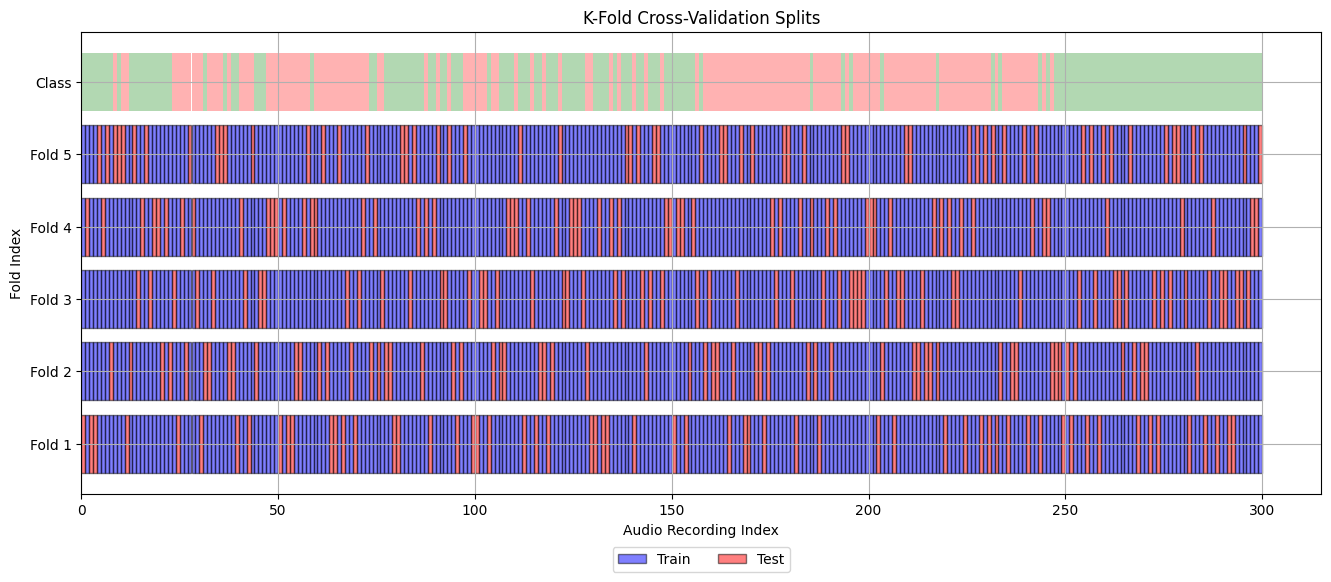

In [24]:
from sono_cross_val import CrossValSplit
cv_strat = CrossValSplit(df_single_frame=df_rms, non_cough_keys=df_from_save[df_from_save['cough_start_end'].isna()].index)
cv_strat_data = cv_strat.cross_val(stratified=True, shuffle=True, plot=True, show_fold_info=False)

### Verification of Stratified Kfold
- It ensure that both classes are equally represented in train and test dataset

In [25]:
res = ['Fold','Audio Train Size','Audio Test Size','Cough Audio Train Size','Cough Audio Test Size','Frames Train Size','Frames Test Size', 'Total Frames']
cv_strat.get_result()[res]

,Fold,Audio Train Size,Audio Test Size,Cough Audio Train Size,Cough Audio Test Size,Frames Train Size,Frames Test Size,Total Frames
0,0,240,60,120,30,63315,19642,82957
1,1,240,60,120,30,68044,14913,82957
2,2,240,60,120,30,69040,13917,82957
3,3,240,60,120,30,63593,19364,82957
4,4,240,60,120,30,67836,15121,82957


### Sample DF of Test Set

In [26]:
print( 'Number of train-test sets:', len(cv_strat_data) )

Number of train-test sets: 5


In [27]:
# test set
df_rms.loc[cv_strat_data[-1][1]]

,key,sf,start,end,max_amp,frame_index,amp,label,rms_amp
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,1024,8.836885e-05,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0,"[[3.749983e-05, 3.749983e-05, 3.749983e-05]]"
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,512,1536,6.821569e-05,1,"[3.0801788e-05, 6.093162e-05, 3.560784e-05, -6...",0,"[[2.913093e-05, 2.913093e-05, 2.913093e-05]]"
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,2048,6.644696e-05,2,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0,"[[1.7608429e-05, 1.7608429e-05, 1.7608429e-05]]"
3,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1536,2560,2.835689e-08,3,"[-1.41313e-08, 1.9094735e-08, -2.2920153e-08, ...",0,"[[2.0175617e-09, 2.0175617e-09, 2.0175617e-09]]"
4,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,2048,3072,9.907748e-16,4,"[-1.5186867e-16, -6.784829e-17, 7.3962843e-16,...",0,"[[1.2983056e-16, 1.2983056e-16, 1.2983056e-16]]"
...,...,...,...,...,...,...,...,...,...
79889,fb0971e2-8ebf-459c-972d-b09d28ae0ca6,16000,154112,155136,2.189022e-04,301,"[4.135922e-05, 2.3030105e-05, -3.8100392e-05, ...",0,"[[5.4343996e-05, 5.4343996e-05, 5.4343996e-05]]"
79890,fb0971e2-8ebf-459c-972d-b09d28ae0ca6,16000,154624,155648,4.464651e-02,302,"[-5.003198e-05, -4.280694e-05, -3.7399324e-05,...",0,"[[0.005788196, 0.005788196, 0.005788196]]"
79891,fb0971e2-8ebf-459c-972d-b09d28ae0ca6,16000,155136,156160,3.747728e-01,303,"[-0.0002433981, -0.0001629504, -3.4685196e-05,...",0,"[[0.048497956, 0.048497956, 0.048497956]]"
79892,fb0971e2-8ebf-459c-972d-b09d28ae0ca6,16000,155648,156672,5.192246e-01,304,"[-0.025054572, -0.029174503, -0.029335529, -0....",0,"[[0.086274676, 0.086274676, 0.086274676]]"


In [28]:
# train set
df_rms.loc[cv_strat_data[-1][0]]

,key,sf,start,end,max_amp,frame_index,amp,label,rms_amp
359,0b2f75d7-f116-4f35-ae4c-f2018eab2794,16000,0,1024,0.000000e+00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[[0.0, 0.0, 0.0]]"
360,0b2f75d7-f116-4f35-ae4c-f2018eab2794,16000,512,1536,0.000000e+00,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[[0.0, 0.0, 0.0]]"
361,0b2f75d7-f116-4f35-ae4c-f2018eab2794,16000,1024,2048,0.000000e+00,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[[0.0, 0.0, 0.0]]"
362,0b2f75d7-f116-4f35-ae4c-f2018eab2794,16000,1536,2560,0.000000e+00,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[[0.0, 0.0, 0.0]]"
363,0b2f75d7-f116-4f35-ae4c-f2018eab2794,16000,2048,3072,0.000000e+00,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[[0.0, 0.0, 0.0]]"
...,...,...,...,...,...,...,...,...,...
82952,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,69632,70656,3.533897e-05,136,"[1.4073834e-07, -1.5136347e-07, 1.5978313e-07,...",0,"[[4.1910025e-06, 4.1910025e-06, 4.1910025e-06]]"
82953,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70144,71168,2.780168e-12,137,"[1.7115064e-12, 2.0663297e-12, 1.2099997e-12, ...",0,"[[2.533051e-13, 2.533051e-13, 2.533051e-13]]"
82954,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70656,71680,1.853762e-06,138,"[-4.7537818e-18, 3.464349e-18, -1.100551e-18, ...",0,"[[2.1910589e-07, 2.1910589e-07, 2.1910589e-07]]"
82955,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,71168,72192,1.853762e-06,139,"[5.8562245e-14, -1.3361285e-14, 4.9188924e-14,...",0,"[[2.1910589e-07, 2.1910589e-07, 2.1910589e-07]]"


In [ ]:
# print( 'Number of train-test sets:', len(cv_strat_data) )
# Number of train-test sets: 5
# Sono Cross Val Split
# StratifiedKFold(n_splits=5, random_state=6, shuffle=True)
# Total Audio Files: 300

Number of train-test sets: 5


# Model Training

### Random Forest Classifier

In [29]:
%%time
# Convert the lists in 'rms' to their mean values
df_rms['rms_amp'] = df_rms['rms_amp'].apply(lambda x: np.mean(np.array(x)))

# Use 'rms_amp' as a feature in your model
X = df_rms[['rms_amp']].values
y = df_rms['label'].values

# Split the data into training and validation sets
# X_train =
# X_val =
# y_train =
# y_val =

# Just use all set for now as test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)

print(f'Validation Accuracy: {accuracy*100:.2f}%')

Validation Accuracy: 88.10%
CPU times: user 14.2 s, sys: 180 ms, total: 14.4 s
Wall time: 14.6 s


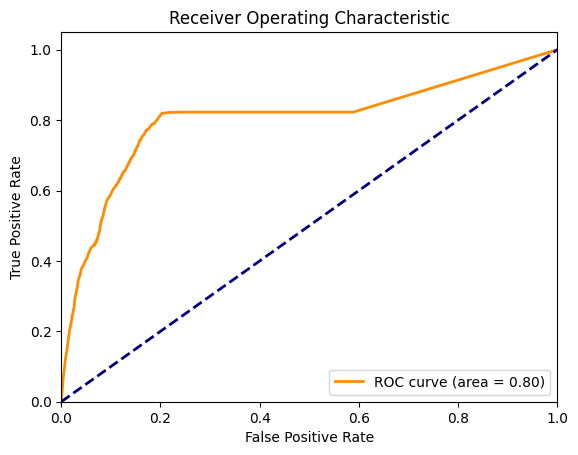

CPU times: user 694 ms, sys: 43.8 ms, total: 737 ms
Wall time: 758 ms


In [30]:
%%time
# Predict the probabilities for the validation set
y_pred_proba = clf.predict_proba(X_val)[:, 1]

# Compute ROC curve and ROC area
# fpr - false positive
# tpr - true positive
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [31]:
print(roc_auc)

0.8028065325200496


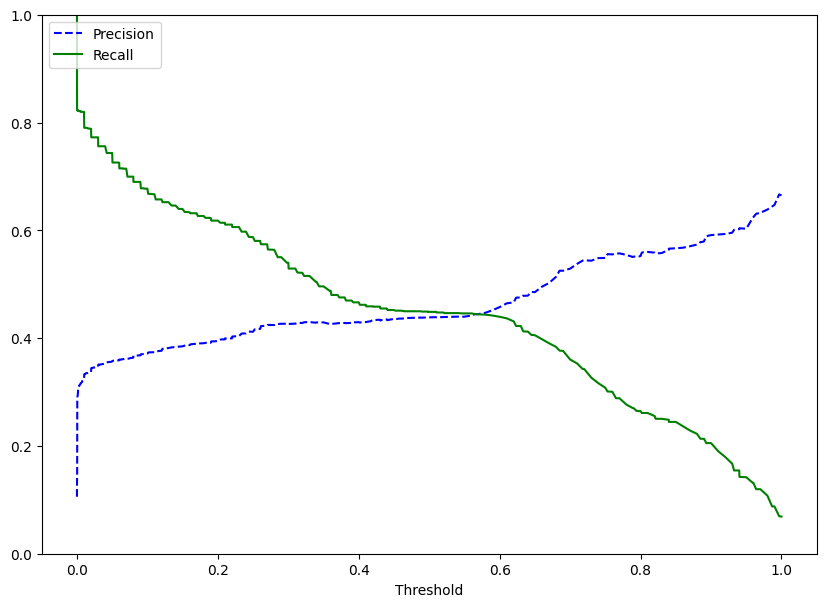

In [32]:
# Precision vs Recall
# Predict probabilities

y_scores = clf.predict_proba(X_val)[:, 1]

# Calculate precision and recall for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

# Plot precision and recall as functions of the threshold value
plt.figure(figsize=(10, 7))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

In [33]:
# The sensitivity (also known as True Positive Rate) and specificity (also known as True Negative Rate),
# you can use the confusion_matrix function from sklearn.metrics.

In [34]:
# Calculate the confusion matrix
# tn - true negative
# fn - false negative
# fp - false positive
# tp - true positive
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity: {sensitivity*100:.2f}%')
print(f'Specificity: {specificity*100:.2f}%')

Sensitivity: 44.87%
Specificity: 93.21%


In [35]:
# Calculate precision and F1-score
precision = precision_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f'Precision: {precision*100:.2f}%')
print(f'F1-score: {f1*100:.2f}%')

Precision: 43.87%
F1-score: 44.36%


### Gaussian Naive Bayes Classifier

In [36]:
# Gaussian Naive Bayes Classifier

# Convert the lists in 'rms' to their mean values
df_rms['rms_amp'] = df_rms['rms_amp'].apply(lambda x: np.mean(np.array(x)))

# Now you can use 'rms' as a feature in your model
X = df_rms[['rms_amp']].values
y = df_rms['label'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gaussian Naive Bayes Classifier
clf = GaussianNB()

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)

print(f'Validation Accuracy: {accuracy*100:.2f}%')


Validation Accuracy: 91.48%


In [40]:
%%time
# Support Vector Model
# Convert the lists in 'rms' to their mean values
df_rms['rms_amp'] = df_rms['rms_amp'].apply(lambda x: np.mean(np.array(x)))


X = df_rms[['rms_amp']].values
y = df_rms['label'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM Model
clf = svm.SVC(gamma='auto', probability=True)

# Train the model
clf.fit(X_train, y_train)
# clf.fit(X, y)

# Make predictions on the validation set
y_pred = clf.predict(X_val)
# clf.predict([[2., 2.]])

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)

print(f'Validation Accuracy: {accuracy*100:.2f}%')

Validation Accuracy: 91.39%
CPU times: user 7min 46s, sys: 379 ms, total: 7min 46s
Wall time: 7min 50s


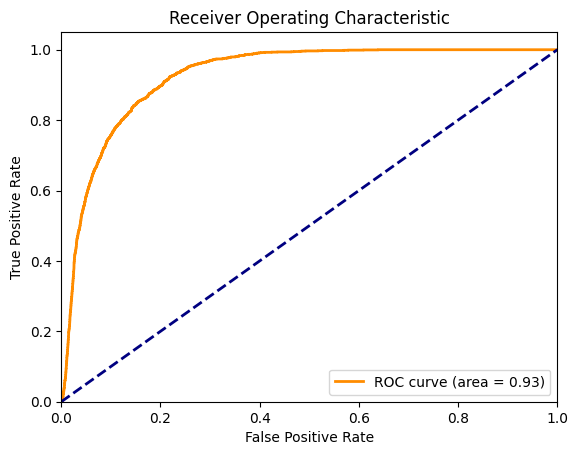

In [41]:
# Predict the probabilities for the validation set
y_pred_proba = clf.predict_proba(X_val)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# get support vectors
clf.support_vectors_

array([[0.09171394],
       [0.01503068],
       [0.07924234],
       ...,
       [0.11371522],
       [0.02830169],
       [0.04501748]])

In [ ]:
# get indices of support vectors
clf.support_

array([    0,     5,     6, ..., 66335, 66338, 66353], dtype=int32)

In [ ]:
# get number of support vectors for each class
clf.n_support_

array([5836, 5697], dtype=int32)

In [ ]:
 # Credits:
    # [1] Repurposed from feature_extraction.py codebase
    # [2] librosa.feature.rmse
    #     https://librosa.org/doc/latest/generated/librosa.feature.rms.html
    # [3] librosa.feature.rmse
    #     http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.feature.rmse.html
    # [4] RandomForestClassifier
    #     https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    # [x] SVM
    #     https://scikit-learn.org/stable/modules/svm.html
    # [x] Gaussian Naive Bayes
    #     https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes
    # [x] 3.4. Metrics and scoring: quantifying the quality of predictions
    #     https://scikit-learn.org/stable/modules/model_evaluation.html

    # [x] Bing CoPilot [June 2024]